In [2]:
!pip install pulp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 27.6 MB/s eta 0:00:0000:0100:01


In [3]:
import math
import numpy as np
import pandas as pd
import datetime
from scipy.interpolate import interp1d

import pyomo.environ as pyomo
import pulp

import os
import csv
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt

In [9]:
root = os.getcwd()
print(root)

/Users/bharatjayaprakash/Documents/Bharat/UMN_Official/CVRG/Charge Scheduling/Charge Scheduling


In [5]:
# Plot Options
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.5
plt.rcParams['axes.titlepad'] = 6.0
plt.rcParams['axes.labelpad'] = 2.0
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['scatter.edgecolors'] = 'face'
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

## Figure 4: Electricity pricing and grid carbon intensity for all four days

(0.0, 1440.0)

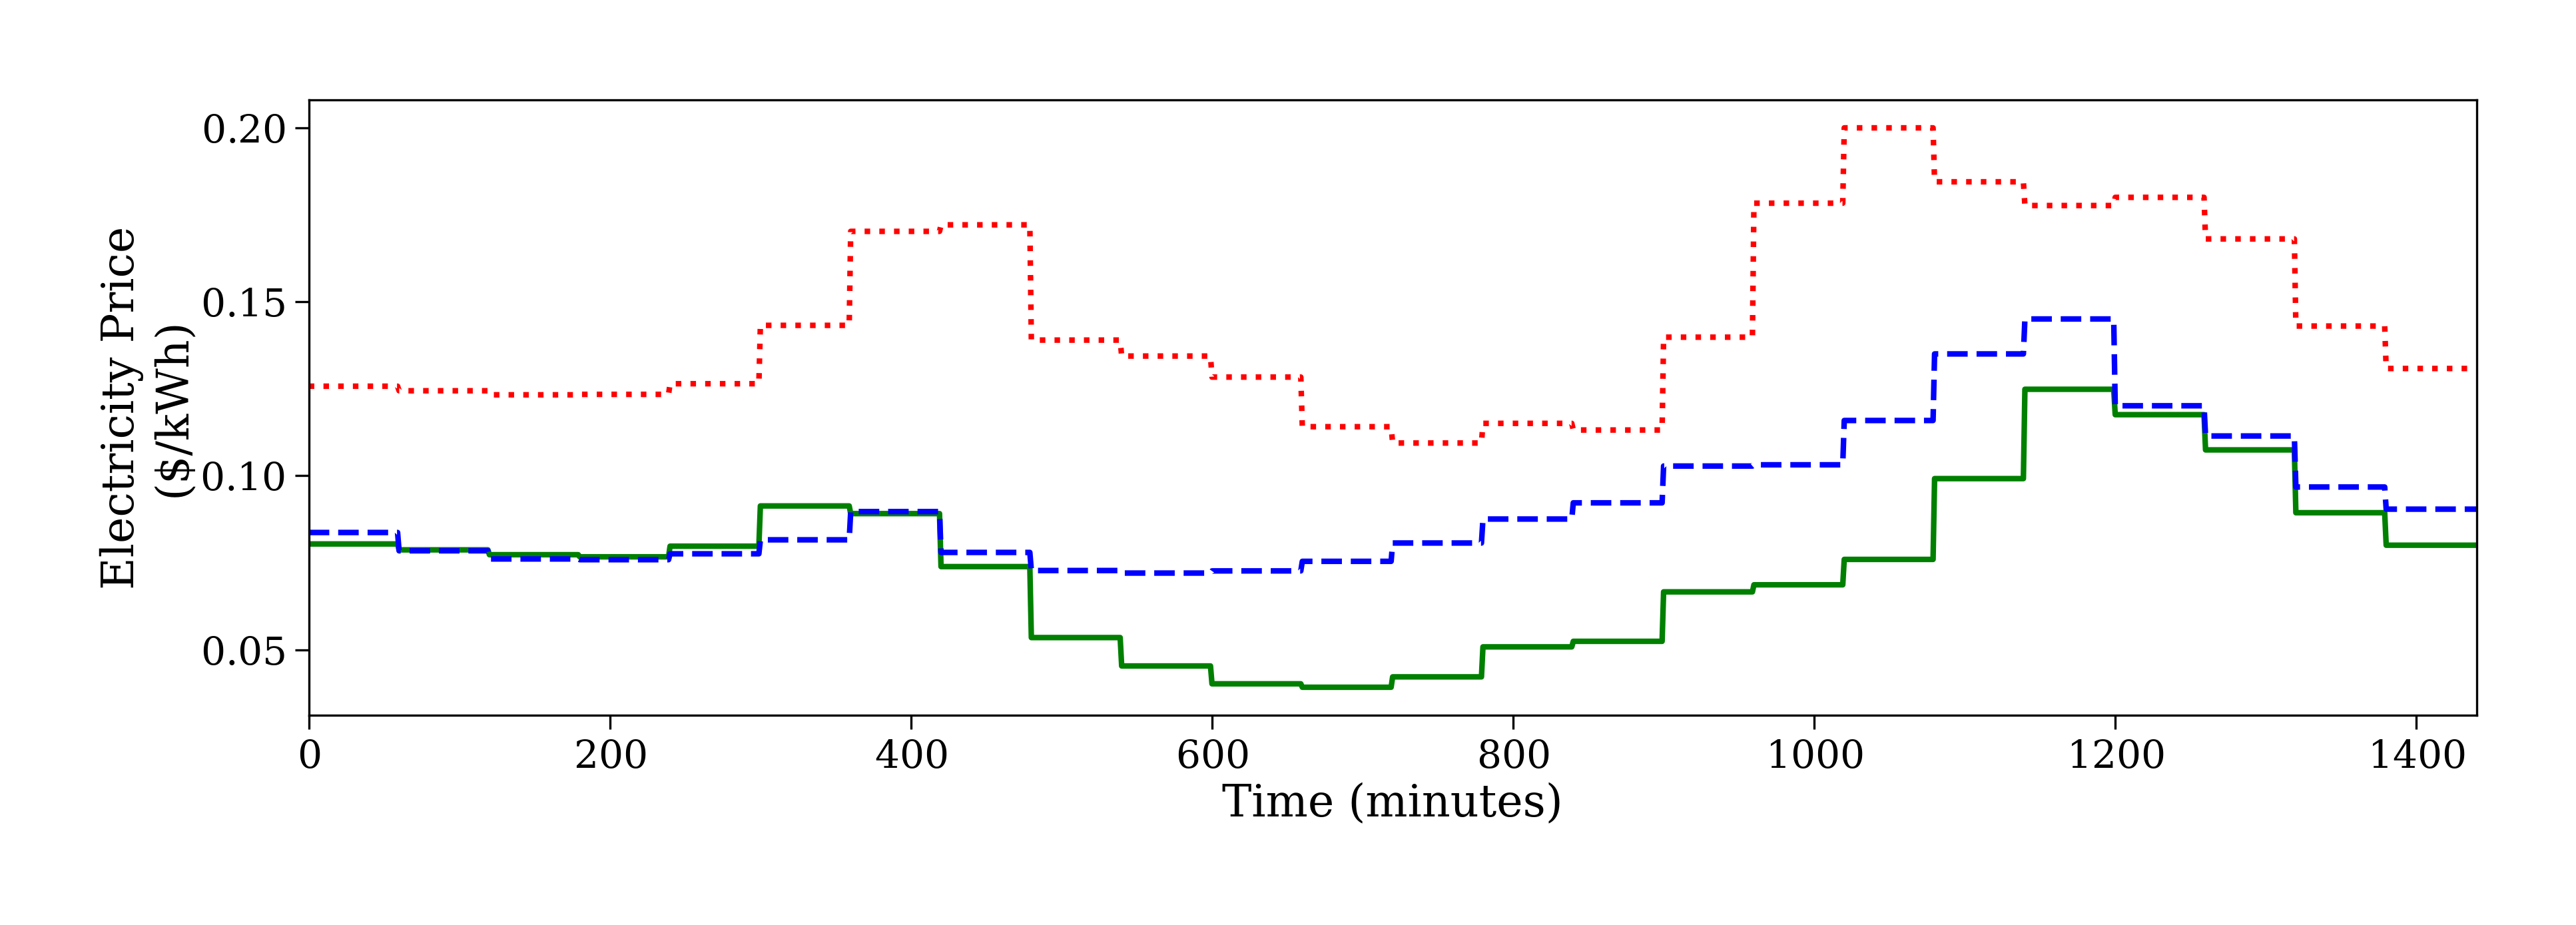

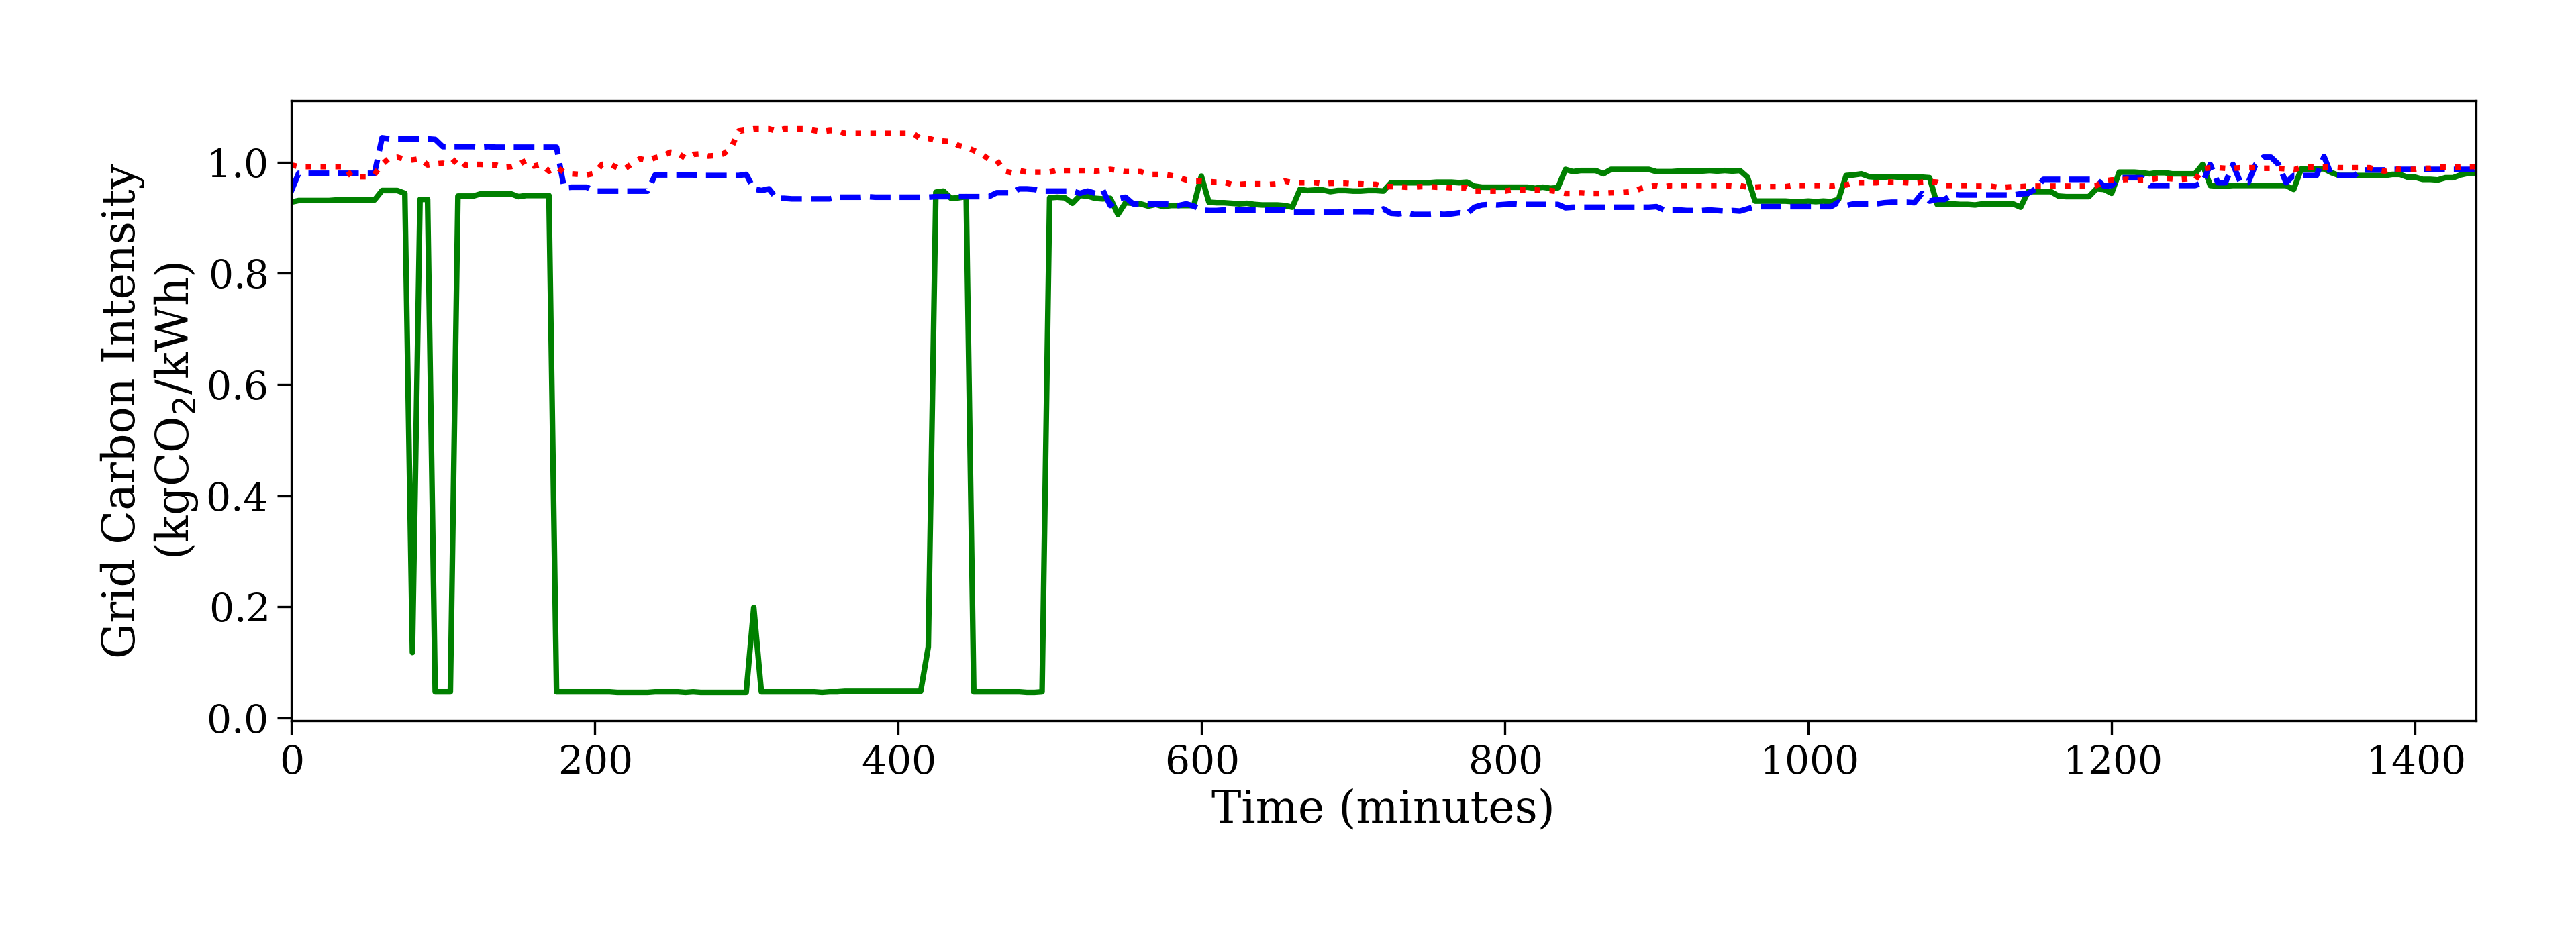

In [10]:
'''
One day from each season, color-coded and with different line styles
'''

summer = os.path.join(root, '2022-05-05.csv')
autumn = os.path.join(root, '2022-08-05.csv')
winter = os.path.join(root, '2022-12-05.csv')


electricity_price = {}
carbon_intensity = {}

season_names = {'summer': summer, 'autumn': autumn, 'winter': winter}

for season_name, season_path in season_names.items():
    forecasts = pd.read_csv(season_path)
    if 'time' not in forecasts.columns:
        forecasts['time'] = [i*5 for i in range(len(forecasts['hour']))]

    assert len(forecasts['time'])==288

    # Extract relevant grid data
    electricity_price[season_name] = forecasts['price'].values / 1000  # converting to $/kWh
    carbon_intensity[season_name] = forecasts['emissions'].values / 1000 # converting to kgCO2/kWh
    time_index = forecasts['time'].values
    #time_index = np.arange(0, len(forecasts) * 5, 5)

    # Add extra datapoint at 1440
    time_index = np.append(time_index, 1440)
    electricity_price[season_name] = np.append(electricity_price[season_name], electricity_price[season_name][-1])
    carbon_intensity[season_name] = np.append(carbon_intensity[season_name], carbon_intensity[season_name][-1])

    # Setup function to interpolate original carbon data
    f_interp = interp1d(time_index, carbon_intensity[season_name], kind='linear')

    # Interpolate input data to get 1 minute resolution
    time_index = np.arange(0, 1441)  # 0 to 1440 inclusive
    electricity_price[season_name] = np.repeat(electricity_price[season_name][:-1], 5)
    electricity_price[season_name] = np.append(electricity_price[season_name], electricity_price[season_name][-1])  # add the last value
    carbon_intensity[season_name] = f_interp(time_index)

    
palette = sns.color_palette("Set1", 3)

fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index, electricity_price['summer'], linestyle='-', label='Electricity Price - Summer', color='green', linewidth='2')  # Solid line
ax1.plot(time_index, electricity_price['autumn'], linestyle='--', label='Electricity Price - Autumn', color='blue', linewidth='2')  # Dashed line
ax1.plot(time_index, electricity_price['winter'], linestyle=':', label='Electricity Price - Winter', color='red', linewidth='2')  # Dotted line


# Set labels
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
ax1.set_xlim(0, 1440)

fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index, carbon_intensity['summer'], linestyle='-', label='Carbon Intensity - Summer', color='green', linewidth='2')  # Solid line
ax2.plot(time_index, carbon_intensity['autumn'], linestyle='--', label='Carbon Intensity - Autumn', color='blue', linewidth='2')  # Dashed line
ax2.plot(time_index, carbon_intensity['winter'], linestyle=':', label='Carbon Intensity - Winter', color='red', linewidth='2')  # Dotted line


# Set labels
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
ax2.set_xlim(0, 1440)
